<a href="https://colab.research.google.com/github/JotaWindus/desafioAI/blob/main/Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving lechuzasdataset.csv to lechuzasdataset (3).csv
Tamaño del conjunto de entrenamiento: (6493, 3)
Tamaño del conjunto de validación: (1392, 3)
Tamaño del conjunto de prueba: (1392, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Entrenando FFNN...
Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 34.1881 - mae: 4.9540 - val_loss: 5.4415 - val_mae: 1.5878
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4061 - mae: 1.5112 - val_loss: 4.5737 - val_mae: 1.2512
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6744 - mae: 1.3656 - val_loss: 4.5088 - val_mae: 1.1764
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4307 - mae: 1.3286 - val_loss: 4.5071 - val_mae: 1.2519
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.5257 - mae: 1.3528 - val_loss: 4.3502 - val_mae: 1.2106
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6388 - mae: 1.3581 - val_loss: 4.3012 - val_mae: 1.2409
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3761 - mae: 1.3290 - val_loss: 4.2685 - val_mae: 1.1791
Epoch 8/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4110 - mae: 1.3098 - val_loss: 4.1990 - val_mae: 1.1689
Epoch 9/100
203/203 ━━━━━━━

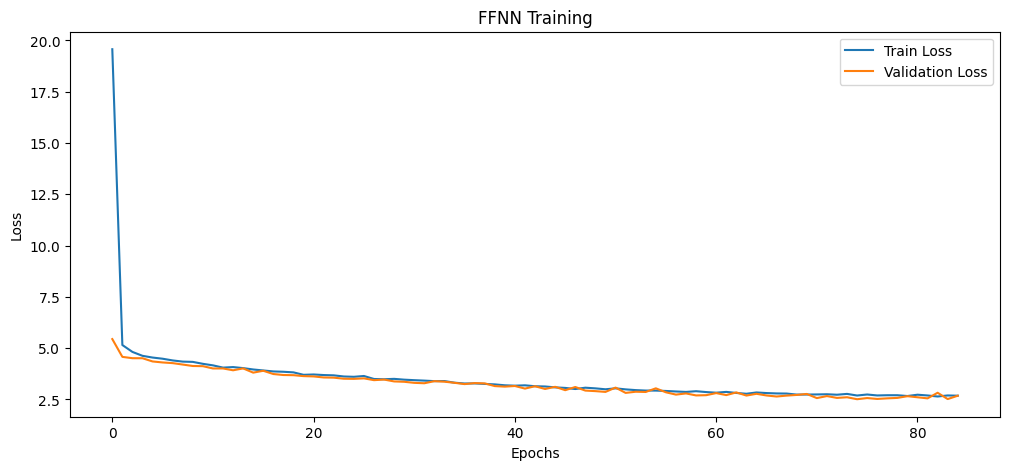

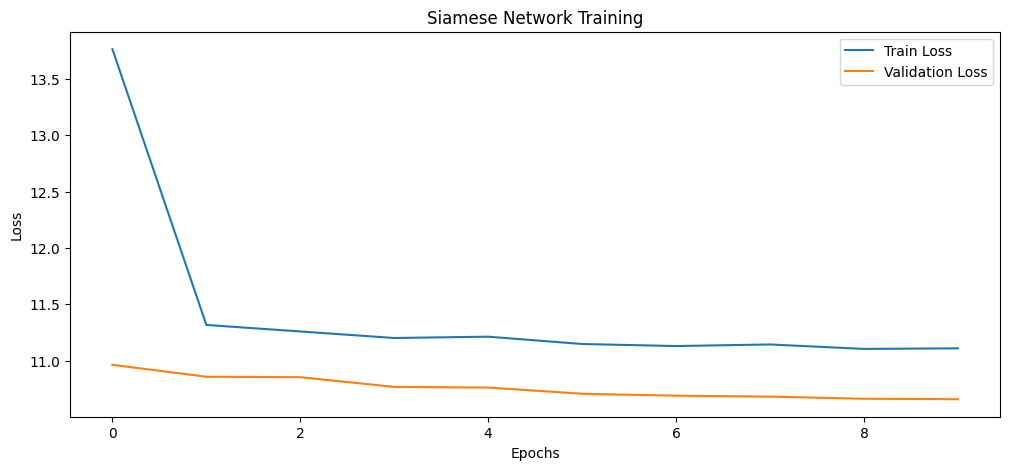

In [3]:
# Instalar TensorFlow si es necesario
!pip install tensorflow

# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

# Cargar archivo desde Google Colab
from google.colab import files
uploaded = files.upload()

# Cargar los datos
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

# Validación y preprocesamiento
# Eliminar valores negativos en 'Potencia' y 'Radiacion'
data = data[data['Potencia'] >= 0]
data = data[data['Radiacion'] >= 0]

# Escalamiento de las variables de entrada
scaler = StandardScaler()
columns_to_scale = ['Radiacion', 'Temperatura', 'Temperatura panel']
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Separar características y variable objetivo
X = data[['Radiacion', 'Temperatura', 'Temperatura panel']].values
y = data['Potencia'].values

# Dividir en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# Crear el modelo FFNN
def create_ffnn(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Salida para regresión
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model

# Crear el modelo Siamesa adaptado
def create_siamese(input_shape):
    input_a = layers.Input(shape=(input_shape,))
    input_b = layers.Input(shape=(input_shape,))

    shared_network = models.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu')
    ])

    processed_a = shared_network(input_a)
    processed_b = shared_network(input_b)

    merged = layers.concatenate([processed_a, processed_b])
    output = layers.Dense(1)(merged)

    model = models.Model(inputs=[input_a, input_b], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model

# Inicializar los modelos
ffnn = create_ffnn(X_train.shape[1])
siamese = create_siamese(X_train.shape[1])

# Callbacks para regularización
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar FFNN
print("\nEntrenando FFNN...")
history_ffnn = ffnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Generar datos dummy para entrenar Siamesa (usualmente necesita pares)
def generate_siamese_data(X, y):
    n_samples = len(X)
    X1 = X
    X2 = X[np.random.permutation(n_samples)]
    y_diff = np.abs(y - y[np.random.permutation(n_samples)])
    return [X1, X2], y_diff

X_train_siamese, y_train_siamese = generate_siamese_data(X_train, y_train)
X_val_siamese, y_val_siamese = generate_siamese_data(X_val, y_val)

print("\nEntrenando Red Neuronal Siamesa...")
history_siamese = siamese.fit(
    X_train_siamese, y_train_siamese,
    validation_data=(X_val_siamese, y_val_siamese),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluar los modelos
print("\nEvaluando FFNN...")
ffnn_eval = ffnn.evaluate(X_test, y_test, verbose=0)
ffnn_preds = ffnn.predict(X_test)

print("\nEvaluando Siamesa...")
X_test_siamese, y_test_siamese = generate_siamese_data(X_test, y_test)
siamese_eval = siamese.evaluate(X_test_siamese, y_test_siamese, verbose=0)
siamese_preds = siamese.predict(X_test_siamese)

# Métricas
print("\nMétricas FFNN:")
print(f"MSE: {mean_squared_error(y_test, ffnn_preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, ffnn_preds):.4f}")
print(f"R²: {r2_score(y_test, ffnn_preds):.4f}")

print("\nMétricas Siamesa:")
print(f"MSE: {mean_squared_error(y_test_siamese, siamese_preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test_siamese, siamese_preds):.4f}")
print(f"R²: {r2_score(y_test_siamese, siamese_preds):.4f}")

# Gráficos de entrenamiento
def plot_training(history, title):
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training(history_ffnn, "FFNN Training")
plot_training(history_siamese, "Siamese Network Training")
